# Tutorial file for the r-place-emergence package

#### Imports

In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import seaborn as sns
import json

import rplacem.canvas_part as cp
import rplacem.compute_variables as cv
import rplacem.variables_rplace2022 as var
import rplacem.utilities as ut
import rplacem.plot_utilities as plot
import rplacem.transitions as tr

### Choose an index from the atlas.json file to identify a composition of interest

The r/place [atlas](https://place-atlas.stefanocoding.me/about)
"is an atlas aiming to chart all the artworks created during the r/place April Fools event on Reddit in 2022. It is made with information to each artwork of the canvas provided by the community. The original code was developed by Roland Rytz and is available under the free AGPL license on GitHub. The currently maintained version of the website is managed by Stefano Haagmans and is obtainable under the same license within a [GitHub fork](https://github.com/placeAtlas/atlas). Initial images are provided by Alex Tsernoh."

Each "artwork" or as we call it here, "composition", is indexed according to a string of numbers, found in the atlas.json file. Here, we choose one arbitrarily for demonstration

In [2]:
atlas_id_index = '000297'

### Load all the pixel data from the npz file

Next, we load all the pixel change data from the npz file. This npz file is a condensed, time-sorted version of the 79 data files provided by reddit from the 2022 r/place experiment. The get_all_pixel_changes() function loads this data and places it into an array with 6 columns

In [3]:
pixel_changes_all = ut.get_all_pixel_changes()

Print the columns of the pixel_changes_all array for reference

In [4]:
print('  seconds: ' + str(pixel_changes_all['seconds']))
print('  x coord: ' + str(pixel_changes_all['xcoor']))
print('  y coord: ' + str(pixel_changes_all['ycoor']))
print('  user id: ' + str(pixel_changes_all['user']))
print(' color id: ' + str(pixel_changes_all['color']))
print('mod event: ' + str(pixel_changes_all['moderator']))

  seconds: [3.15000000e-01 1.26710000e+01 1.66260000e+01 ... 3.00590172e+05
 3.00590195e+05 3.00590207e+05]
  x coord: [  42  999   44 ...  770 1046    0]
  y coord: [  42  999   42 ...  866 1721 1999]
  user id: [4068945 4068946 4068947 ... 2778754 1591567  583562]
 color id: [16  7 10 ... 31 31 31]
mod event: [False False False ... False False False]


### Define two types of CanvasPart objects

The CanvasPart class is a superclass with subclasses CanvasComposition and CanvasArea. You can think of a CanvasPart as a part of the canvas defined by a spatial border, which can be either defined by the edge of a particular artwork composition as defined by the r/place Atlas or it can be defined by an arbitrary user-defined border path, which can take any shape. The maximum size of a user-defined border is the size of the canvas itself. 

##### Define a CanvasCompsition object

To define a CanvasComposition object, you must supply the atlas composition id index and the pixel change data loaded from the npz file. The constructor then finds and sets the border path, the x and y coordinates inside the border, and the pixel changes within the border of the composition. 

In [5]:
atlas, atlas_size = ut.load_atlas()

In [6]:
canvas_comp = cp.CanvasPart(id = atlas_id_index, atlas = atlas, verbose = True)

set border path (with _get_atlas_border() if composition)
set coordinates (with _get_bounded_coords() if is not rectangle)
_reject_off_times()
set pixel changes with _find_pixel_changes_in_boundary()
    find pixels inside boundary
    sort pixel_changes vs coordinates
    determine if the pixel change is in the active timerange
    make pixel_changes output
    find redundant pixel changes
    find changes with cheated cooldown
_set_has_loc_jump()


In [7]:
ut.check_time('cp.CanvasPart(id=atlas_id_index, pixel_changes_all=pixel_changes_all, atlas=atlas)')
# getting rid of ind for loop: 0.892 vs 1.632

         456701 function calls (418017 primitive calls) in 2.595 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    2.595    2.595 {built-in method builtins.exec}
        1    0.000    0.000    2.595    2.595 <string>:1(<module>)
        1    0.000    0.000    2.595    2.595 canvas_part.py:99(__init__)
        1    0.780    0.780    2.327    2.327 canvas_part.py:344(_find_pixel_changes_in_boundary)
        5    1.347    0.269    1.348    0.270 {method 'argsort' of 'numpy.ndarray' objects}
        1    0.051    0.051    0.951    0.951 canvas_part.py:430(_find_cheated_pix_change)
46445/7761    0.125    0.000    0.822    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
        7    0.000    0.000    0.484    0.069 fromnumeric.py:51(_wrapfunc)
        1    0.005    0.005    0.457    0.457 canvas_part.py:454(_find_redundant_pix_change)
        2    0.000    0.000    0.45

In [8]:
print(canvas_comp.__str__())

CanvasPart 
Atlas Composition, id: 000297,         
Rectangle, 1 time-dependent border_path(s)
7735 pixels in total, x in [1800, 1890], y in [539, 623]        
419109 pixel changes (including 419109 in composition time ranges)        

Description: 
The titular protagonist of the Kirby video game series, developed by HAL Laboratory and published by Nintendo.

YouTube streamer Ludwig used his chat to overtake the Kirby built by Russian streamer Bratishkinoff. The art was overall loved by all communities (including Bratishkinoff) and saw minimal sabotage throughout the remaining time. 

Pixel changes: 
[( 99663.452,  267, 4850869,  5,  True, False, False, False, False)
 ( 99670.916, 1125, 5678690,  2,  True, False, False, False, False)
 ( 99682.882, 7002, 3066810,  5,  True, False, False, False, False) ...
 (300573.411, 6357, 1743202, 31,  True, False, False,  True, False)
 (300583.048, 7684, 8855771, 31,  True, False, False,  True, False)
 (300584.884, 7569, 9899334, 31,  True, False, F

##### Define a CanvasArea object
To define a CanvasArea object, you must supply the border path and the pixel changes from the npz file. 
The border path is a numpy array of x,y points that form the path of the border of the canvas

In [9]:
border_path = [[[0,0],[0,10],[10,10],[10,0]]]
canvas_area = cp.CanvasPart(border_path=border_path, pixel_changes_all=pixel_changes_all)
canvas_area.description = 'The top left 100 pixels'

In [10]:
print(canvas_area)
print(canvas_area.border_path)
print(np.array(border_path))

CanvasPart 
user-defined area, name: rectangle_0.0_to_10.10,         
Rectangle, 1 time-dependent border_path(s)
121 pixels in total, x in [0, 10], y in [0, 10]        
197538 pixel changes (including 197538 in composition time ranges)        

Description: 
The top left 100 pixels 

Pixel changes: 
[(2.17030000e+01, 24, 4068948, 22,  True, False, False, False, False)
 (1.69534000e+02,  0, 4068955, 27,  True, False, False, False, False)
 (4.90058000e+02, 12, 4068959, 25,  True, False, False, False, False) ...
 (3.00589027e+05,  0, 1256236, 31,  True, False, False,  True, False)
 (3.00589360e+05,  1,  364556, 31,  True, False, False,  True, False)
 (3.00589387e+05,  0, 1295679, 31,  True, False, False,  True, False)]        

[[[ 0  0]
  [ 0 10]
  [10 10]
  [10  0]]]
[[[ 0  0]
  [ 0 10]
  [10 10]
  [10  0]]]


### Get the pixel changes over time, plot, and save a movie of the frames

Now, we can start to examine how the two CanvasPart objects change over time. 
Lets' choose a time step interval of 900 seconds (15 minutes), and a total time 
of 20 hours (20*3600 seconds).

In [11]:
time_interval= 20*60 #seconds
time_end = 70*3600 #seconds
time_start = 40*3600
times_comp = np.arange(time_start, time_end, time_interval)
times_comp[0]=0

First, let's plot the canvas_comp object for the specified time steps. You'll notice the plotting function returns a list of indices that allow us to quickly select the pixel change data at different time points inside the boundary. The time_inds_list_comp will come in handy for time-step calculations later on. 

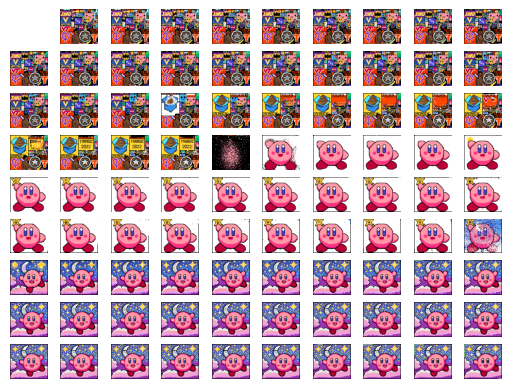

In [12]:
(file_size_bmp, 
file_size_png, 
pixels_vst, 
num_active_pix,
time_inds_list_comp) = cv.save_part_over_time(canvas_comp,
                                             times_comp, #seconds,
                                             delete_bmp = True, 
                                             record_pixels = True,
                                             remove_inactive = False,
                                             delete_png = False, # keep the png files
                                             show_plot = True)

We can do the same for the canvas_area object

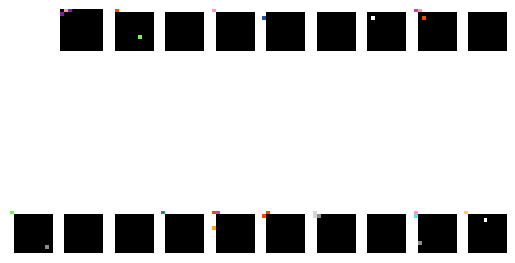

In [13]:
time_interval= 60*60 #seconds
time_end = 20*3600 #seconds
time_start = 0
times_area = np.arange(time_start, time_end, time_interval)

(file_size_bmp_area, 
file_size_png_area, 
pixels_vst_area, 
num_active_pix_area,
time_inds_list_area) = cv.save_part_over_time(canvas_area,
                                              times_area,
                                              delete_bmp = True,
                                              delete_png = False,
                                              show_plot = True)

##### Save the frames as a movie

In [14]:
image_path = os.path.join(os.getcwd(), 'figs', '000297','VsTime')
image_path_area = os.path.join(os.getcwd(), 'figs', 'rectangle_0.0_to_10.10','VsTime')

Save frames as a movie

In [16]:
ut.save_movie(image_path, 
              movie_tool='moviepy',
              fps=6,
              codec='mpeg4',#'libx264',
              video_type='mov')# 'mp4'

ut.save_movie(image_path_area, 
              movie_tool='moviepy',
              fps=6,
              codec='mpeg4',#'libx264',
              video_type='mov')# 'mp4'


Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/000297/VsTime/canvaspart_fps6.mov
Moviepy - Building video /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov.
Moviepy - Writing video /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov



Moviepy - Done !
Moviepy - video ready /Users/annie/Code/Repositories/r-place-emergence/figs/rectangle_0.0_to_10.10/VsTime/canvaspart_fps6.mov


#### Saving and loading the timestep data

In [17]:
cp.save_canvas_part_time_steps(canvas_comp,  
                               time_inds_list_comp,
                               times_comp,
                               file_size_bmp,
                               file_size_png)

In [18]:
(canvas_comp, 
 time_inds_list_comp,
 times_comp,
 file_size_bmp,
 file_size_png) = cp.load_canvas_part_time_steps()

### Plot the compressed file size ratio over time

Next, we'll perform calculations to further analyze the CanvasPart objects. We can use the compressed file size as a way to characterize the 'complexity' of a part of the canvas. We'll plot the ratio of the compressed file size to the original file size for both the canvas composition and the canvas area

#### Calculate number of pixel changes and touched pixels for thermodynamic quantities


In [19]:
(num_pixel_changes, 
 num_touched_pixels,
 num_users) = cv.calc_num_pixel_changes(canvas_comp,
                                         time_inds_list_comp,
                                         time_interval)

##### Plot

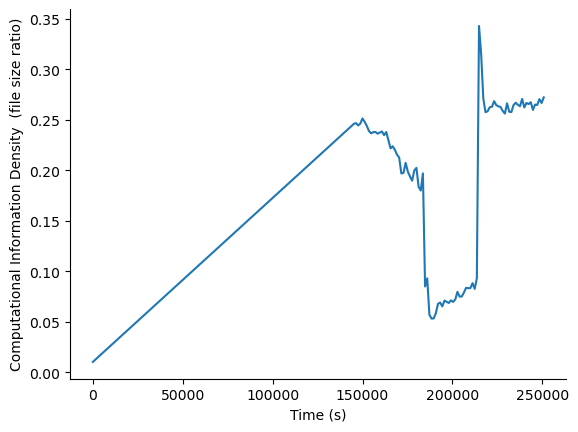

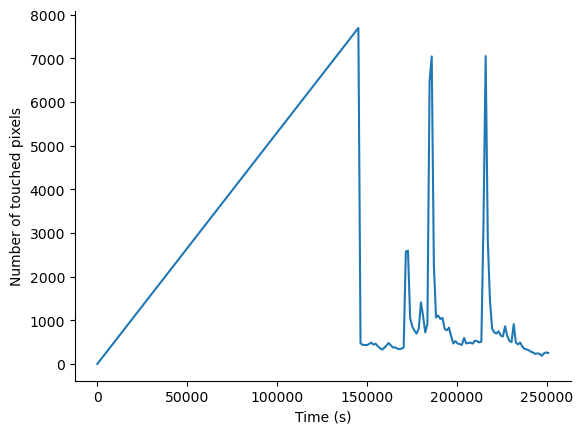

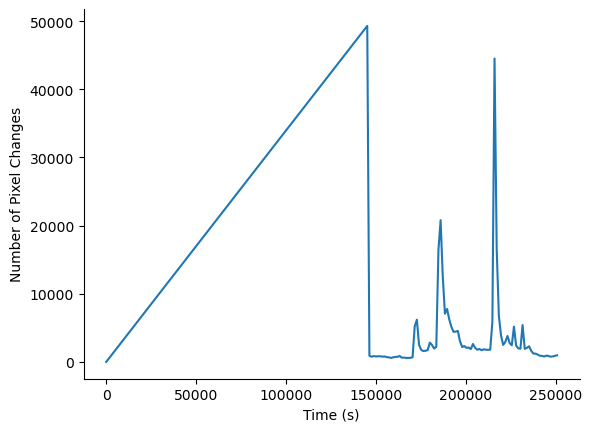

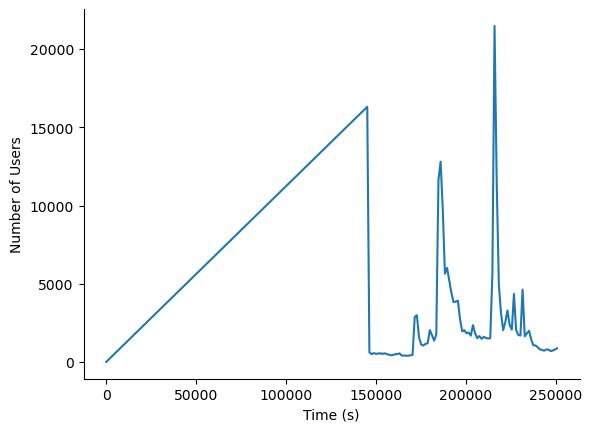

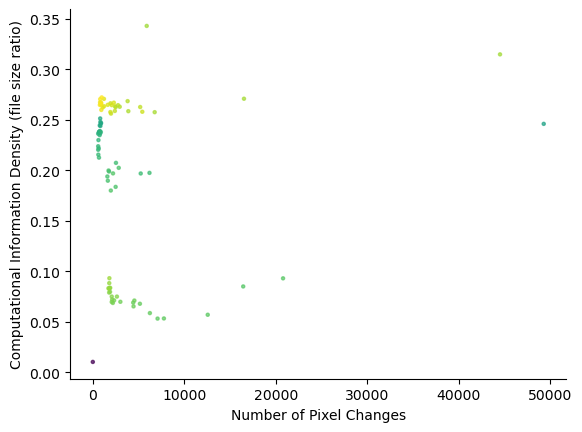

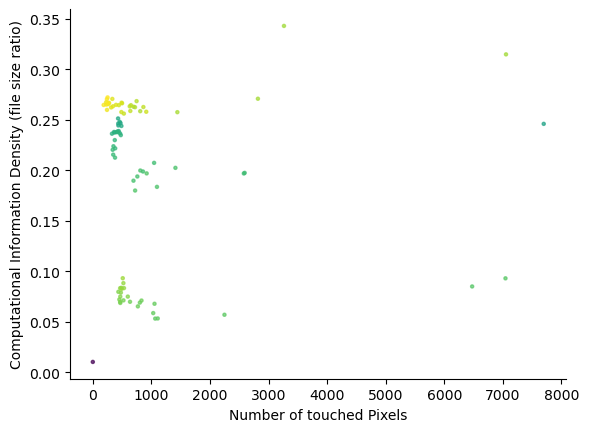

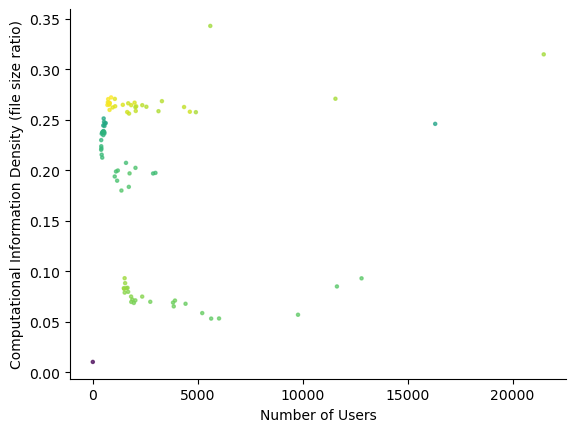

In [20]:
(fig_cid_vs_time, 
fig_num_touched_pix_vs_time, 
fig_num_pix_changes_vs_time, 
fig_users_vs_time,
fig_cid_vs_num_pix_changes,
fig_cid_vs_num_touched_pix,
fig_cid_vs_num_users)= plot.compression_vs_pixel_changes(num_pixel_changes, 
                                                            num_touched_pixels, 
                                                            num_users,
                                                            times_comp,
                                                            file_size_png, 
                                                            file_size_bmp)

manipulate the plots

(0.0, 5000.0)

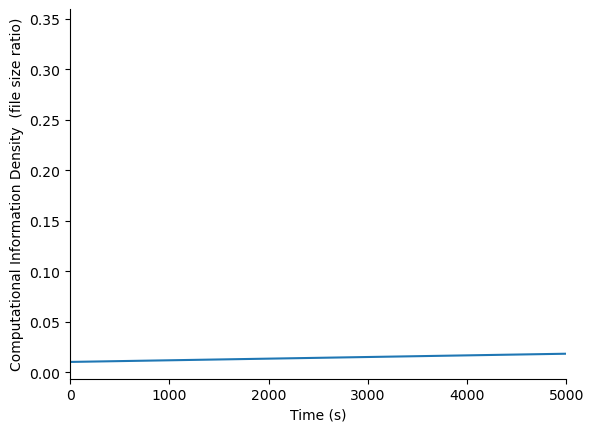

In [21]:
plt.figure()
plt.sca(fig_cid_vs_time.gca())
plt.xlim([0,5000])

### Calculate the stability

In [22]:
# for two time intervals
time_bins = 150
time_interval = var.TIME_WHITEONLY / time_bins  # seconds
time_ranges = np.arange(0, var.TIME_WHITEONLY+time_interval-1e-4, time_interval)


time_bins2 = 500
time_interval2 = var.TIME_WHITEONLY / time_bins  # seconds
time_ranges2 = np.arange(0, var.TIME_WHITEONLY+time_interval-1e-4, time_interval)

In [23]:
(stability_vs_time, 
instab_vs_time_norm,
pixels1, 
pixels2, 
pixels3) = cv.stability(canvas_comp,
                        save_images=False,
                        t_lims=time_ranges,
                        save_pickle=False
                        )

(stability_vs_time2, 
instab_vs_time_norm2,
pixels1, 
pixels2, 
pixels3) = cv.stability(canvas_comp,
                        save_images=False,
                        t_lims=time_ranges2,
                        save_pickle=False
                        )

In [24]:
ut.check_time('cv.stability(canvas_comp, save_images=False,t_lims=time_ranges,save_pickle=False)')

         12667 function calls (12517 primitive calls) in 0.913 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.913    0.913 {built-in method builtins.exec}
        1    0.000    0.000    0.913    0.913 <string>:1(<module>)
        1    0.505    0.505    0.913    0.913 compute_variables.py:77(stability)
1305/1155    0.011    0.000    0.336    0.000 {built-in method numpy.core._multiarray_umath.implement_array_function}
      150    0.000    0.000    0.141    0.001 <__array_function__ internals>:177(take_along_axis)
      150    0.137    0.001    0.141    0.001 shape_base.py:56(take_along_axis)
      150    0.000    0.000    0.112    0.001 <__array_function__ internals>:177(argsort)
      150    0.000    0.000    0.112    0.001 fromnumeric.py:1012(argsort)
      150    0.000    0.000    0.112    0.001 fromnumeric.py:51(_wrapfunc)
      150    0.111    0.001    0.111    0.001 {method 'argsort

(0.0, 0.002)

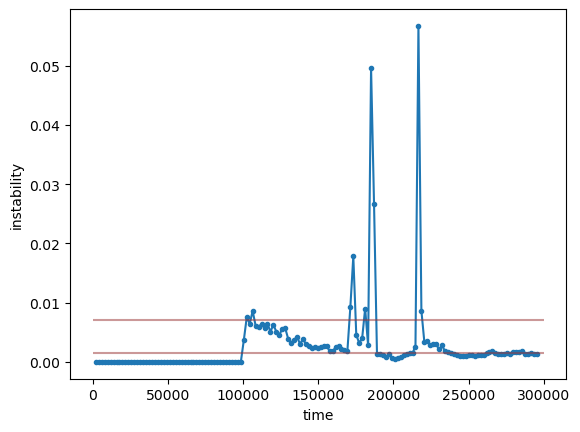

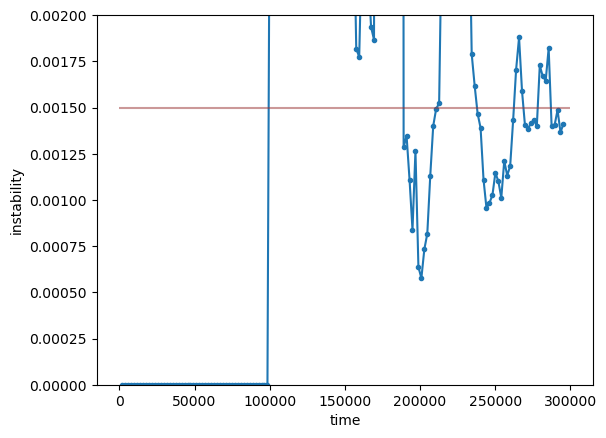

In [48]:
plt.figure()
plt.plot(time_ranges[1:], instab_vs_time_norm,'.-')
plt.hlines(0.007, 0, 300000, alpha=0.5, color = [0.6, 0.2, 0.2])
plt.hlines(0.0015, 0, 300000, alpha=0.5, color = [0.6, 0.2, 0.2])
plt.ylabel('instability')
plt.xlabel('time')

plt.figure()
plt.plot(time_ranges[1:], instab_vs_time_norm,'.-')
plt.hlines(0.007, 0, 300000, alpha=0.5, color = [0.6, 0.2, 0.2])
plt.hlines(0.0015, 0, 300000, alpha=0.5, color = [0.6, 0.2, 0.2])
plt.ylabel('instability')
plt.xlabel('time')
plt.ylim([0, 0.002])

### Look at transitions

In [49]:
# to be considered a transition:
# 1. the instability has to reach at least 0.007
# 2. the instability must be below .0015 before and after the transition
# 3. there must be 4 stable intervals before and after the transition
# 4. the length of the transition must be no longer than 3 intervals
#print((1-stability_vs_time)*300/t_interval)
(full_transition, 
full_transition_times) = tr.find_transitions(time_ranges,
                                             instab_vs_time_norm,
                                             cutoff=7e-3, 
                                             cutoff_stable=1.5e-3,
                                             len_stable_intervals=3,
                                             dist_stableregion_transition=3,
                                             )

In [50]:
print(full_transition)

[[ 95 106 109 110 120 132]]


In [51]:
print(full_transition_times)

[[187093.1178  210725.93268 214664.73516 218603.53764 236328.1488
  261930.36492]]


#### Check for redundant pixel changes and jumps

In [29]:
id_no_jump = '000021'
id_jump = '000202'

In [61]:
canvas_comp_no_jump = cp.CanvasPart(id = id_no_jump)
canvas_comp_jump = cp.CanvasPart(id = id_jump)

In [78]:
print('has_loc_jump: ' + str(canvas_comp_no_jump.has_loc_jump) + '\n')
print('pixel change colors: ' + str(canvas_comp_no_jump.pixel_changes['color'][0:100]) + '\n')
print('pixel change redundancies: ' + str(canvas_comp_no_jump.pixel_changes['redundant_col'][0:100]) + '\n')
print('pixel change redundancies: ' + str(canvas_comp_no_jump.pixel_changes['redundant_colanduser'][0:100]) + '\n')
print(canvas_comp_no_jump)

has_loc_jump: False

pixel change colors: [25  5 25 13 16  7  5  5 22 27  7  5 25 26 26 13 26 26 25 26  9  9  5 16
 20 29 17 25 25  5  5 16 13 25 29 13 26  5 26  5  7 25 19  5 16  9 25  5
 16 13 29  5 27 25 27  5  5 25 27  5 25  5 29 26  5 25  5  5 16  5 16 25
 26  7  7 25  5 17 29  5  5  5  5  5  5  5  5  5  5  5  5  5 25  5  5 31
  5  5  5  5]

pixel change redundancies: [False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False  True False  True False False False False False
 False  True False False]

pixel change 

In [80]:
print('has_loc_jump: ' + str(canvas_comp_jump.has_loc_jump) + '\n')

has_loc_jump: True

